# Project proposal: Stock-price prediction

Stock market prediction has attracted much attention from academia as well as business. Due
to the non-linear, volatile and complex nature of the market, it is quite difficult to predict. As
the stock markets grow bigger, more investors pay attention to develop a systematic approach
to predict the stock market. Since the stock market is very sensitive to the external information,
the performance of previous prediction systems is limited by merely considering the traditional
stock data. New forms of collective intelligence have emerged with the rise of the Internet (e.g.
Google Trends, Wikipedia, etc.). The changes on these platforms will significantly affect the
stock market. In addition, both the financial news sentiment and volumes are believed to have
impact on the stock price.

In this project, you should develop and evaluate a prediction model that could be used to predict
the stocks’ short-term movement, and price. Besides historical data directly from the stock
market, some external data sources should also be considered as inputs to the model.

In summary, the contributions to this work are listed below:

1. Detect the potential factors(features) that could impact the stock market and acquire the
data from disparate data sources: 
    
    (a) publicly available market information on stocks such as Yahoo Finance, including opening/closing prices, trade volume, etc.; 

    (b) commonly used technical indicatorsfrom Yahoo finance that reflect price variation over time such as Stochastic Oscillator (%K), the Larry William (LW) % R Indicator and the Relative Strength Index (RSI) ; 

    (c) daily counts of Google Trends on the stocks of interest; 
     
    (d) the number of unique visitors for pertinent Wikipedia pages per day.

2. Use a variable selection method such as PCA, Correlation Coefficient or any other suitable methods to filter the most important features.

3. Make use of Artificial Neural Networks and most important featuresfrom disparate data sources to build the forecasting model.

4. The proposed model should allow investors to predict the next-day Closing, Opening or both prices for a particular stock or index.

5. Evaluate the prediction model based on different metrics(ex. MSE, MAPE) and provide decision making suggestions for the investors.

Note 1: You can use any stock such as AAPL for Apple, GOOG for Google, and etc.

Note 2. Use the best practices you learned in the course to solve the problem.
To obtain more information about this project, you can refer to the Chapter 2 of the
following paper: Application of machine learning techniques for stock market
prediction, Bin Weng, 2017.


# Factors 
Hvilke variabler må være med i modellen?

1. price on market open and close, trade volume, etc
2. technical indicators: Stochastic, Willams %R, Relative Strength Index ...
simple moving average?
3. daily count of Google Trends on the stock of interest
4. the number of unique visitors for pertinent Wikipedia pages per day 




In [1]:
# import guide https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb

!pip install yfinance
!pip install pytrends --upgrade
!pip install --upgrade --user git+https://github.com/GeneralMills/pytrends

Requirement already up-to-date: pytrends in c:\users\joaki\appdata\roaming\python\python38\site-packages (4.7.4)
  Cloning https://github.com/GeneralMills/pytrends to c:\users\joaki\appdata\local\temp\pip-req-build-u5m5vlwv
  Created wheel for pytrends: filename=pytrends-4.7.4-py3-none-any.whl size=15478 sha256=7a0c5cb2e7dbc7a8a1cb6680e6b0023ef37ec6c555714b5f3560969eab257139
  Stored in directory: C:\Users\joaki\AppData\Local\Temp\pip-ephem-wheel-cache-cguyou6z\wheels\16\ff\41\df76076b615c3bc8c806e9f375bbccba902b4c66f0472d99b1
Successfully built pytrends
  Attempting uninstall: pytrends
    Found existing installation: pytrends 4.7.4
    Uninstalling pytrends-4.7.4:
      Successfully uninstalled pytrends-4.7.4


# Libraries
Yahoo finance - yfinance: get stock data..


In [4]:
import yfinance as yf # eller bare pandas datareader?
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import pageviewapi as wik
from pytrends.request import TrendReq
pytrend = TrendReq()
from datetime import date

Enter desired ticker

In [5]:
# Yahoo finance - get data
TICKER = 'AAPL'

stock = yf.Ticker(TICKER)
stock.info
# stock.history()

{'zip': '95014',
 'sector': 'Technology',
 'fullTimeEmployees': 147000,
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand r

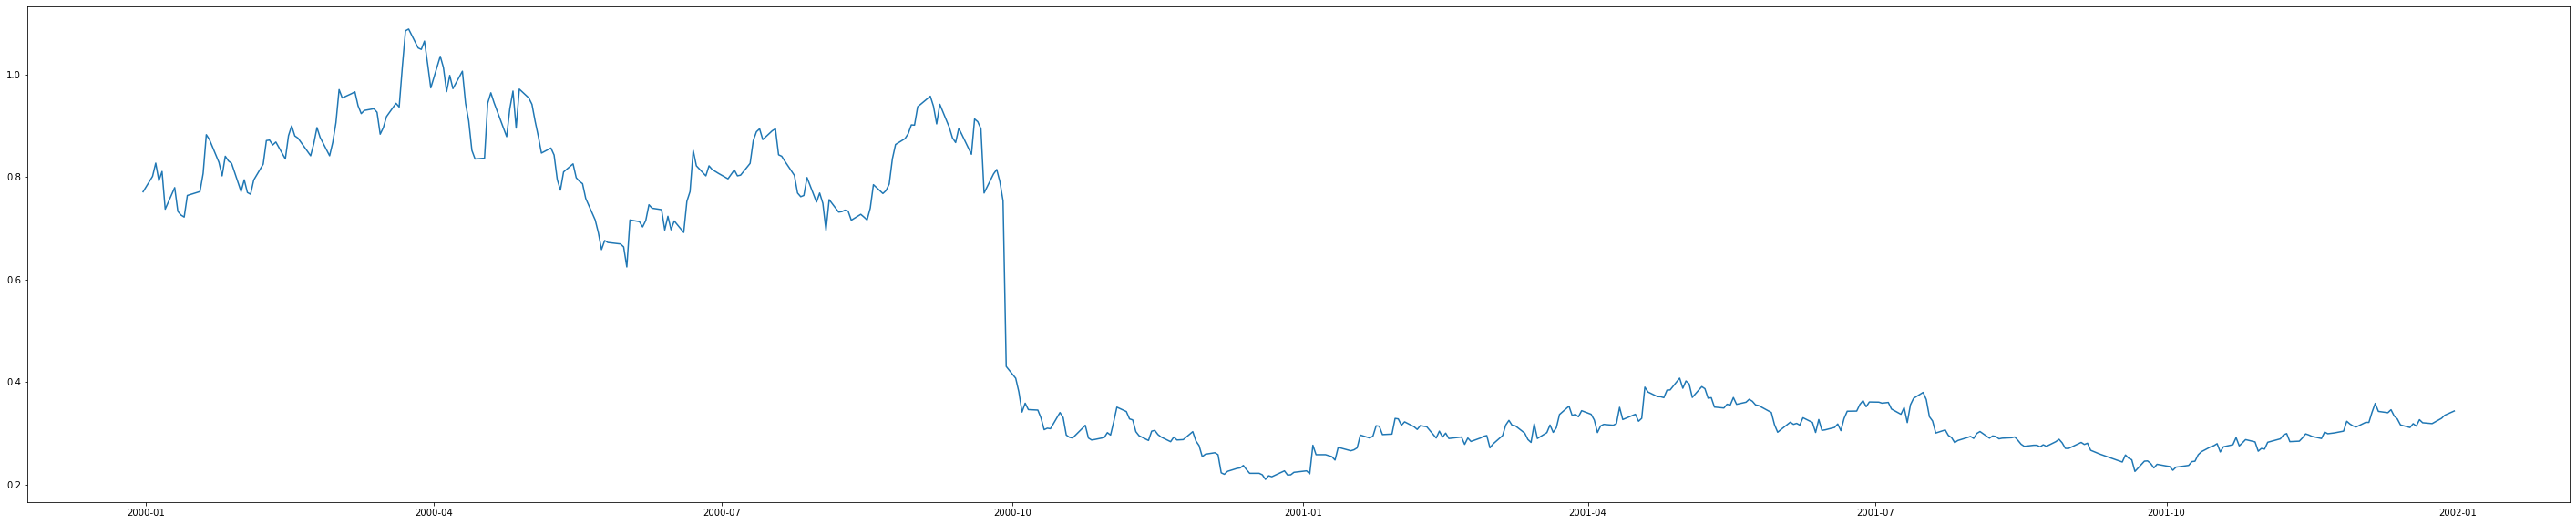

In [6]:
stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')
stock_open_price = stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')['Open']

# setup figure
plt.ylim = stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')[['Open','Close']].values.max() * 1.1
plt.figure(figsize=(50,10))

plt.plot(stock_open_price.index, stock_open_price.values)


In [7]:
df = stock.history(period= "1y")

Stochastic oscillator: 

\begin{equation}
\tag{1}
\% \mathrm{K}  = \frac{C -L14}{H14 -L14}
\end{equation}

Where $C =$ most recent closing price, $H14 =$ highest traded price for last 14 day period, and $L14 =$ lowest traded price for last 14 day period.   

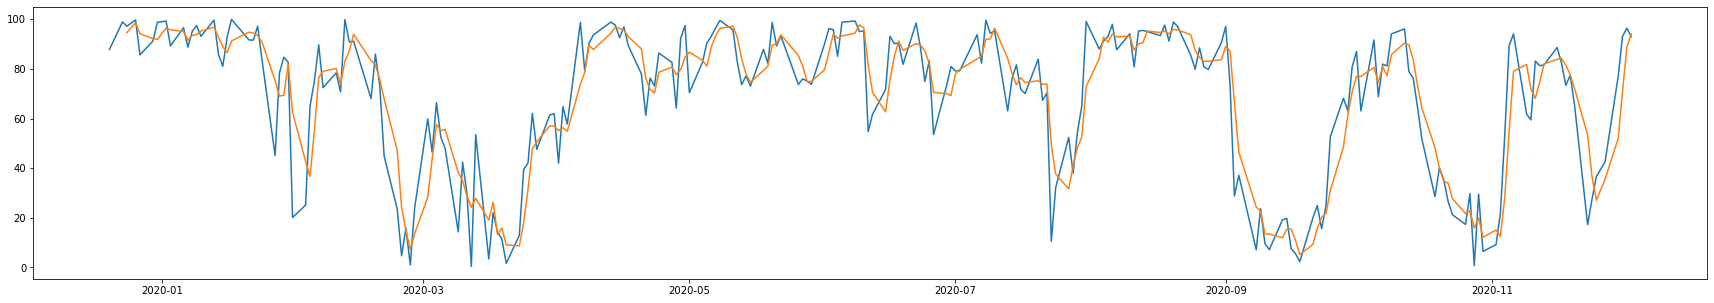

In [8]:
df["L14"] = df["Low"].rolling(window = 14).min()

df["H14"] = df["High"].rolling(window = 14).max()

df["%K"] = 100 * ((df["Close"] - df["L14"]) / (df["H14"] - df["L14"]))

df["%D"] = df["%K"].rolling(window = 3).mean()

plt.figure(figsize=(30,5))
stochastic_oscillator = plt.plot(df.index, df[['%K','%D']])

In [9]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,L14,H14,%K,%D
Date,,,,,,,,,,,
2019-12-03,63.504647,63.804580,63.008040,63.784916,114430400,0.0,0.0,NaN,NaN,NaN,NaN
2019-12-04,64.183180,64.733874,64.087296,64.347893,67181600,0.0,0.0,NaN,NaN,NaN,NaN
2019-12-05,64.851886,65.368166,64.591289,65.291946,74424400,0.0,0.0,NaN,NaN,NaN,NaN
2019-12-06,65.759051,66.624429,65.714793,66.553131,106075600,0.0,0.0,NaN,NaN,NaN,NaN
2019-12-09,66.378588,66.575262,65.127230,65.621384,128042400,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-27,116.570000,117.489998,116.220001,116.589996,46691300,0.0,0.0,112.589996,121.989998,42.553185,35.531924
2020-11-30,116.970001,120.970001,116.809998,119.050003,169410200,0.0,0.0,112.589996,120.989998,76.904828,52.017926
2020-12-01,121.010002,123.470001,120.010002,122.720001,128166800,0.0,0.0,112.589996,123.470001,93.106621,70.854878


Relative Strenght Index (RSI):

The Formula for the Relative Strenght Index is:
\begin{aligned} &\text{RSI} = {100} - \frac{100}{{1} + {\text{Previous Average Gain}\over\text{- Previous Average Loss}}}\\ &\textbf{where}\\ &\text{Previous Average Gain} = \text{Average price in a }\\ &\text{period, typically 14 days.}\\ &\text{Previous Average Loss} = \text{Average loss in a }\\ &\text{period, typically 14 days.} \end{aligned} 
​	  
RSI ia a indicator that tells if a stock is overbought or oversold. The indicator operates wiyhin values form 0 to 100. In general the stock is conscidered 
overbougth when the induicator goes above 70, and oversold as the indicator goes below 30. Indicator values at 80 and 20 is also useful in some cases.
​	 

Prevoius average gain is typically in a lookback
period of 14 days.
This is also the case in previous average loss. The lookback period is 
equal for both parameters.



In [10]:
def RSI(data, time_window):
    diff = data.diff(1).dropna()

    up_change = 0 * diff
    down_change = 0 * diff

    up_change[diff > 0] = diff[diff > 0]
    down_change[diff < 0] = diff[diff < 0]

    up_change_avg = up_change.ewm(com = time_window-1, min_periods = time_window).mean()
    down_change_avg = down_change.ewm(com = time_window-1, min_periods = time_window).mean()

    rs = abs(up_change_avg/down_change_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

df["RSI"] = RSI(df["Close"], 14)



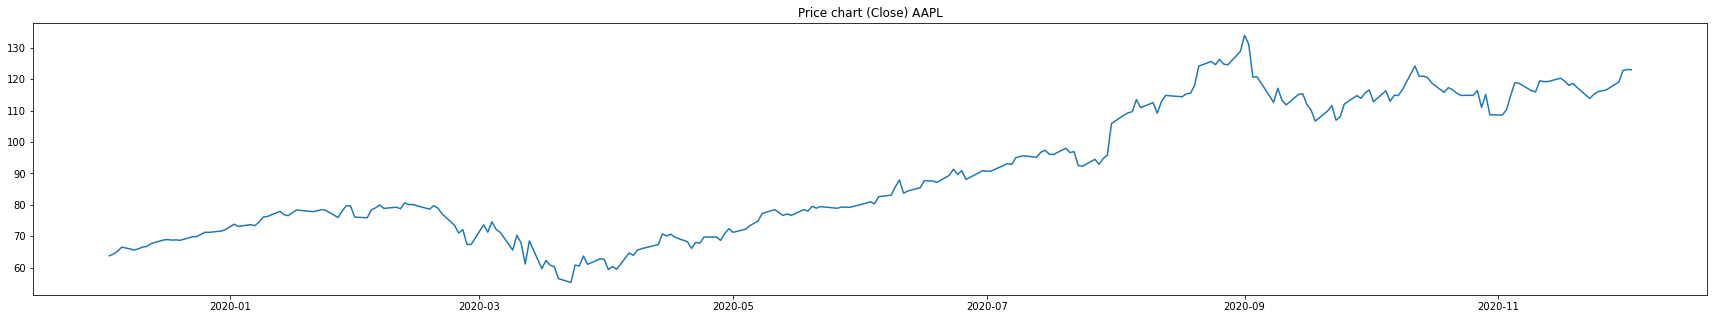

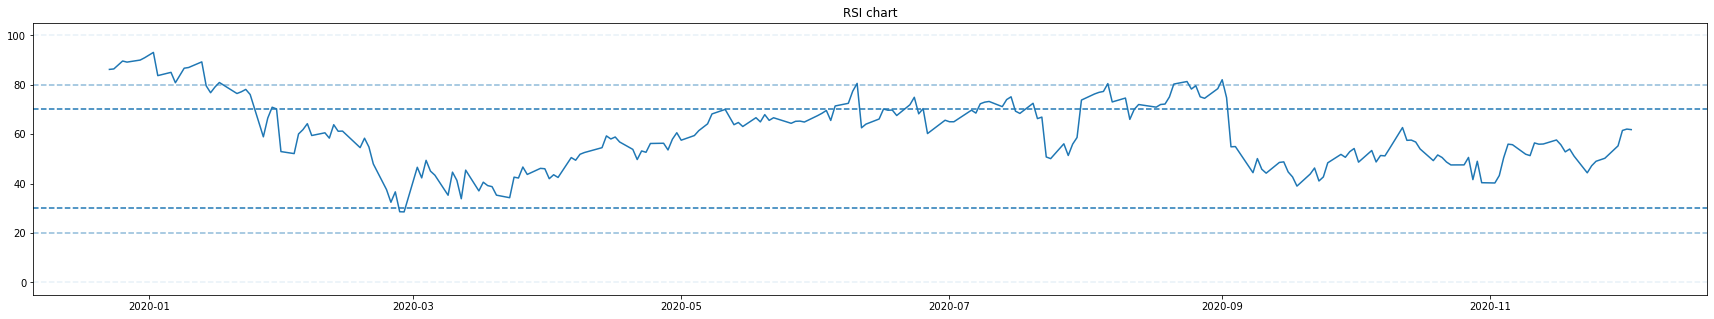

In [11]:
plt.figure(figsize=(30,5))
plt.plot(df.index, df['Close'])
plt.title('Price chart (Close) '+ TICKER)
plt.show()

plt.figure(figsize=(30,5))
plt.title('RSI chart')
plt.plot(df.index, df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')

plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)
plt.show()

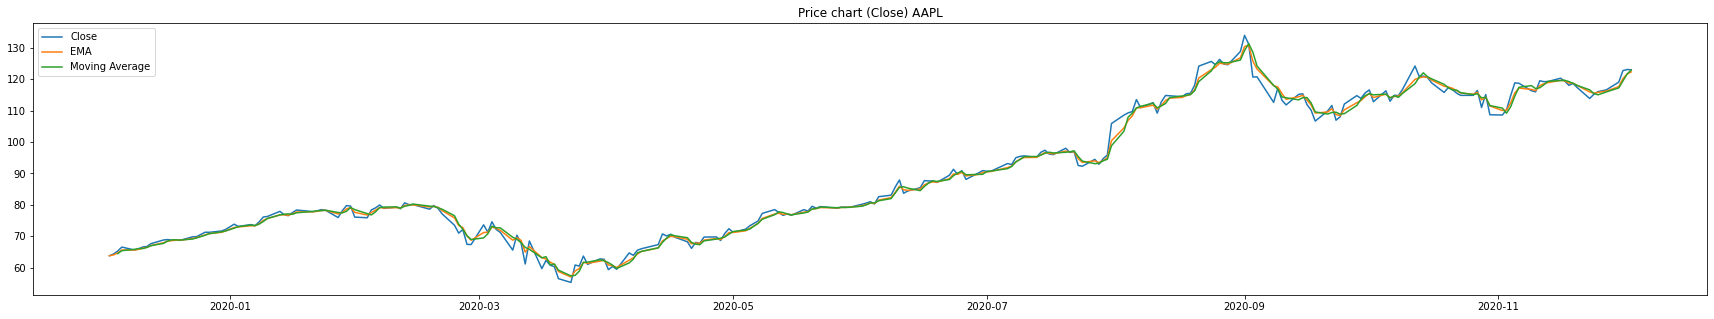

In [12]:
# Moving Average + Exponential moving average

def Moving_Average(data, time_window):
    data_rolling = data.rolling(window= time_window).mean()
    return data_rolling

df["Moving Average"] = Moving_Average(df["Close"], 3)

def EMA(data):
    ema = data.ewm(span= 3, adjust=False).mean()       #https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#stats-moments-exponentially-weighted

    return ema

df["EMA"] = EMA(df["Close"])

fig_estimators = plt.figure(figsize=(30,5))
ax_estimators = fig_estimators.add_subplot()
ax_estimators.plot(df.index, df[['Close']], label = "Close")
ax_estimators.plot(df.index, df[["EMA"]], label = "EMA")
ax_estimators.plot(df.index, df[["Moving Average"]], label = "Moving Average")
plt.title('Price chart (Close) ' + TICKER)
plt.legend()
plt.show()

In [13]:
# Values above 100 indicates that the closeing price is above moving average, and below 100 indicates that the opposite is true. 
# Values far from 100 indicates sudden rappid movements in the stock closing price 

def Disparity(data, data_shift):
    disparity = (data/data_shift)*100
    return disparity

df["Disparity"] = Disparity(df["Close"], df["Moving Average"]) 

In [14]:
# Calculation of momentum 1

def Momentum_1(data, data_shifted):
    momentum1 = (data/data_shifted)*100
    return momentum1

df["Momentum_1"] = Momentum_1(df["Close"], df["Close"].shift(5))

def Momentum_2(data, data_shifted):
    momentum2 = (data-data_shifted)*100
    return momentum2 

df["Momentum_2"] = Momentum_2(df["Close"], df["Close"].shift(5))

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,L14,H14,%K,%D,RSI,Moving Average,EMA,Disparity,Momentum_1,Momentum_2
Date,,,,,,,,,,,,,,,,,
2019-12-03,63.504647,63.804580,63.008040,63.784916,114430400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,63.784916,NaN,NaN,NaN
2019-12-04,64.183180,64.733874,64.087296,64.347893,67181600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,64.066404,NaN,NaN,NaN
2019-12-05,64.851886,65.368166,64.591289,65.291946,74424400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,64.474918,64.679175,101.267203,NaN,NaN
2019-12-06,65.759051,66.624429,65.714793,66.553131,106075600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,65.397657,65.616153,101.766844,NaN,NaN
2019-12-09,66.378588,66.575262,65.127230,65.621384,128042400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,65.822154,65.618768,99.694981,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-27,116.570000,117.489998,116.220001,116.589996,46691300,0.0,0.0,112.589996,121.989998,42.553185,35.531924,50.253299,115.929998,116.190687,100.569308,98.272081,-205.000305
2020-11-30,116.970001,120.970001,116.809998,119.050003,169410200,0.0,0.0,112.589996,120.989998,76.904828,52.017926,55.272944,117.223333,117.620345,101.558282,101.457309,171.000671
2020-12-01,121.010002,123.470001,120.010002,122.720001,128166800,0.0,0.0,112.589996,123.470001,93.106621,70.854878,61.512363,119.453334,120.170173,102.734681,107.790956,887.000275


In [15]:
# Rate of change

def Rate_Of_Change(data, momentum2):
    ROC = (data/momentum2)*100
    return ROC

df["ROC"] = Rate_Of_Change(df["Close"], df["Momentum_2"])

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,L14,H14,%K,%D,RSI,Moving Average,EMA,Disparity,Momentum_1,Momentum_2,ROC
Date,,,,,,,,,,,,,,,,,,
2019-12-03,63.504647,63.804580,63.008040,63.784916,114430400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,63.784916,NaN,NaN,NaN,NaN
2019-12-04,64.183180,64.733874,64.087296,64.347893,67181600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,64.066404,NaN,NaN,NaN,NaN
2019-12-05,64.851886,65.368166,64.591289,65.291946,74424400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,64.474918,64.679175,101.267203,NaN,NaN,NaN
2019-12-06,65.759051,66.624429,65.714793,66.553131,106075600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,65.397657,65.616153,101.766844,NaN,NaN,NaN
2019-12-09,66.378588,66.575262,65.127230,65.621384,128042400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,65.822154,65.618768,99.694981,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-27,116.570000,117.489998,116.220001,116.589996,46691300,0.0,0.0,112.589996,121.989998,42.553185,35.531924,50.253299,115.929998,116.190687,100.569308,98.272081,-205.000305,-56.873084
2020-11-30,116.970001,120.970001,116.809998,119.050003,169410200,0.0,0.0,112.589996,120.989998,76.904828,52.017926,55.272944,117.223333,117.620345,101.558282,101.457309,171.000671,69.619611
2020-12-01,121.010002,123.470001,120.010002,122.720001,128166800,0.0,0.0,112.589996,123.470001,93.106621,70.854878,61.512363,119.453334,120.170173,102.734681,107.790956,887.000275,13.835396


In [16]:
print(df["Close"].tail(15), df["Close"].shift(5).tail(10))      #Test of shifting function to use in momentum formulas

Date
2020-11-12    119.209999
2020-11-13    119.260002
2020-11-16    120.300003
2020-11-17    119.389999
2020-11-18    118.029999
2020-11-19    118.639999
2020-11-20    117.339996
2020-11-23    113.849998
2020-11-24    115.169998
2020-11-25    116.029999
2020-11-27    116.589996
2020-11-30    119.050003
2020-12-01    122.720001
2020-12-02    123.080002
2020-12-03    122.997002
Name: Close, dtype: float64 Date
2020-11-19    119.209999
2020-11-20    119.260002
2020-11-23    120.300003
2020-11-24    119.389999
2020-11-25    118.029999
2020-11-27    118.639999
2020-11-30    117.339996
2020-12-01    113.849998
2020-12-02    115.169998
2020-12-03    116.029999
Name: Close, dtype: float64


In [17]:
print(df["Close"].tail(1), df.iloc[-5:-4,3:4])

Date
2020-12-03    122.997002
Name: Close, dtype: float64                  Close
Date                  
2020-11-27  116.589996


In [18]:
help(sklearn)

Help on package sklearn:

NAME
    sklearn

DESCRIPTION
    Machine learning module for Python
    
    sklearn is a Python module integrating classical machine
    learning algorithms in the tightly-knit world of scientific Python
    packages (numpy, scipy, matplotlib).
    
    It aims to provide simple and efficient solutions to learning problems
    that are accessible to everybody and reusable in various contexts:
    machine-learning as a versatile tool for science and engineering.
    
    See http://scikit-learn.org for complete documentation.

PACKAGE CONTENTS
    __check_build (package)
    _build_utils (package)
    _config
    _distributor_init
    _isotonic
    _loss (package)
    base
    calibration
    cluster (package)
    compose (package)
    conftest
    covariance (package)
    cross_decomposition (package)
    datasets (package)
    decomposition (package)
    discriminant_analysis
    dummy
    ensemble (package)
    exceptions
    experimental (package)
    ext

,Apple Inc.,AAPL,Apple,isPartial
date,,,,
2018-01-01 00:00:00,0,0,81,False
2018-01-01 01:00:00,0,0,81,False
2018-01-01 02:00:00,0,0,80,False
2018-01-01 03:00:00,0,0,78,False
2018-01-01 04:00:00,0,0,73,False
...,...,...,...,...
2018-01-31 20:00:00,0,2,78,False
2018-01-31 21:00:00,0,3,81,False
2018-01-31 22:00:00,0,3,84,False


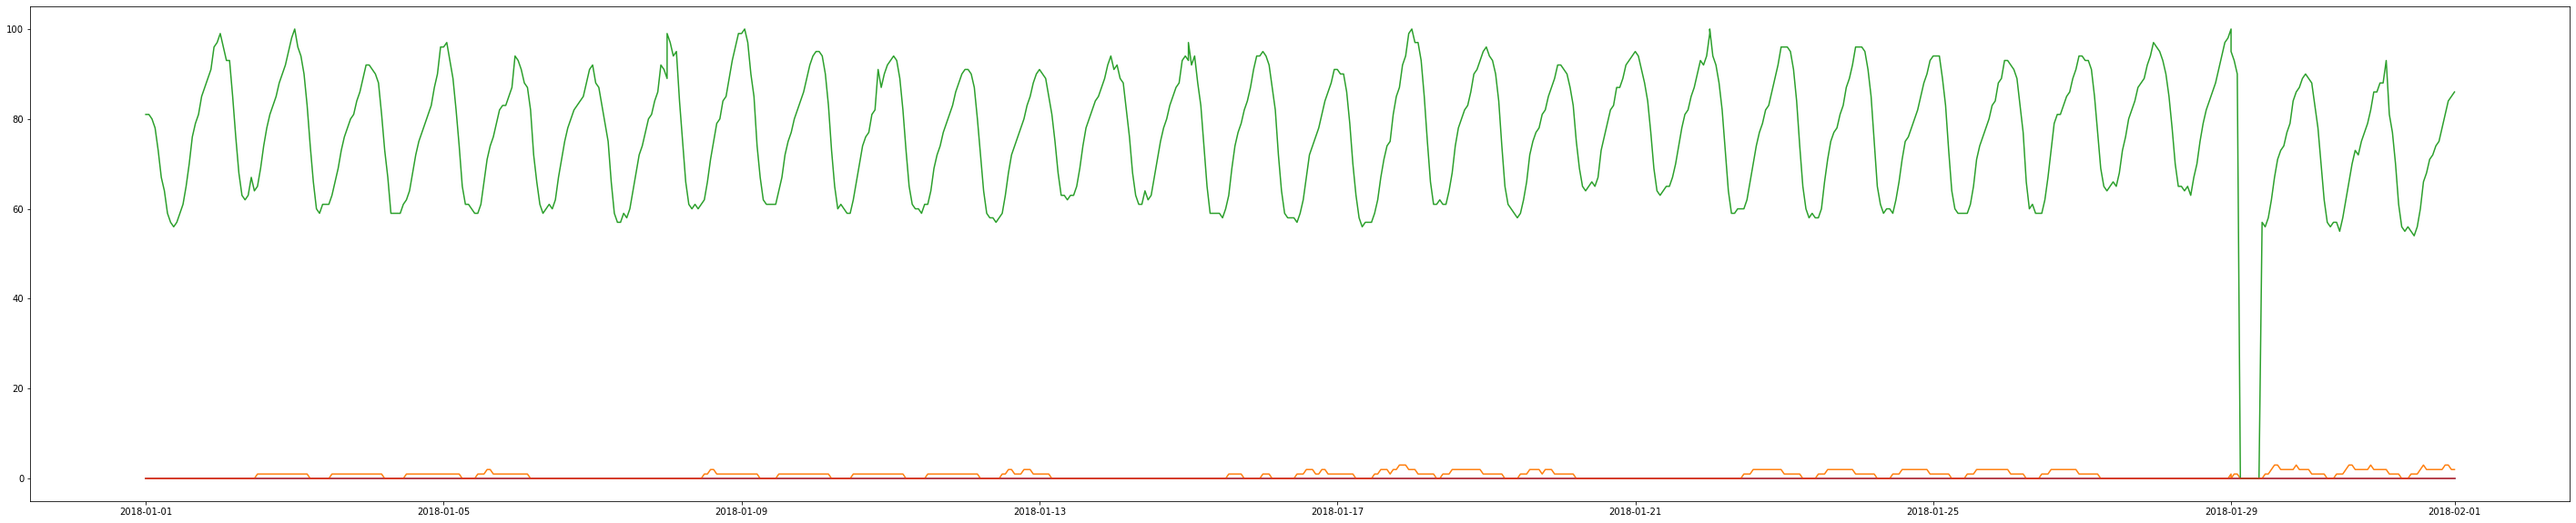

In [19]:
def get_company_name(comp_name):
    if len(comp_name) > 2:
        return comp_name[0:1]
    else:
        return comp_name[0]


# Google trends data
keyword_list = [stock.info['shortName'], stock.info['symbol'], get_company_name(stock.info['shortName'].split(' '))]

#pytrend.build_payload(kw_list=[keyword_list])

trend = pytrend.get_historical_interest(keyword_list, year_start=2018, month_start=1, day_start=1, hour_start=0, year_end=2018, month_end=2, day_end=1, hour_end=0, cat=0, geo='', gprop='', sleep=0)
plt.figure(figsize=(50,10))
plt.plot(trend)
trend

In [25]:
def datagetter(TICKER,  interval = '1d', start = '2017-01-01', end = date.today().strftime("%Y-%m-%d")):        # Gjer "end" funksjonen at vi ikkje får siste dagen med? 
    """Function that takes ticker, and name of firm as input and retrieves relevant data as pandas dataframe"""
    tick = yf.Ticker(TICKER)
    Name =tick.info['shortName']

    ### Section where data is from yahoo
    out_df= tick.history(interval = interval,  start=start, end=end)[['Open','Close']]
    
    ##Williams %R indicator
    # williams = out_df['Close'].rolling(14).apply(lambda x: (x.max() -x[-1])/(x.max()- x.min()))     #den er feil
    # out_df['williams_R'] = williams

    # ### wikipedia data
    wikistart = start.replace('-','')
    wikiend = end.replace("-","")
    try:
        wikidata = wik.per_article('en.wikipedia', Name, wikistart, wikiend,access='all-access', agent='all-agents', granularity='daily')
        df_wiki = pd.DataFrame(wikidata['items'])
        df_wiki['timestamp'] = pd.to_datetime(df_wiki['timestamp'], format = '%Y%m%d%H')
        df_wiki.set_index('timestamp', inplace = True)
        out_df['wikiviews'] = df_wiki['views']
    except:
        print('fungerte ikke')
    
    ### Google trends

    return out_df.dropna() #drops nan values, at least 14 drops because of williams R is computed by 14day rolling window, nan for first days

apple_data = datagetter('AAPL')

print(apple_data)
print(df["RSI"])


                  Open       Close  wikiviews
Date                                         
2017-01-03   27.195443   27.277639      13461
2017-01-04   27.207185   27.247108      12926
2017-01-05   27.223622   27.385668      13036
2017-01-06   27.425592   27.690971      12804
2017-01-09   27.700360   27.944603      14646
...                ...         ...        ...
2020-11-25  115.550003  116.029999      16164
2020-11-27  116.570000  116.589996      15071
2020-11-30  116.970001  119.050003      16257
2020-12-01  121.010002  122.720001      16849
2020-12-02  122.019997  123.080002      16760

[987 rows x 3 columns]
Date
2019-12-03          NaN
2019-12-04          NaN
2019-12-05          NaN
2019-12-06          NaN
2019-12-09          NaN
                ...    
2020-11-27    50.253299
2020-11-30    55.272944
2020-12-01    61.512363
2020-12-02    62.071302
2020-12-03    61.848288
Name: RSI, Length: 254, dtype: float64


In [29]:
stock_data = apple_data[['Open','Close']]
wiki_data = apple_data[["wikiviews"]]

print(stock_data, wiki_data)

                  Open       Close
Date                              
2017-01-03   27.195443   27.277639
2017-01-04   27.207185   27.247108
2017-01-05   27.223622   27.385668
2017-01-06   27.425592   27.690971
2017-01-09   27.700360   27.944603
...                ...         ...
2020-11-25  115.550003  116.029999
2020-11-27  116.570000  116.589996
2020-11-30  116.970001  119.050003
2020-12-01  121.010002  122.720001
2020-12-02  122.019997  123.080002

[987 rows x 2 columns]             wikiviews
Date                 
2017-01-03      13461
2017-01-04      12926
2017-01-05      13036
2017-01-06      12804
2017-01-09      14646
...               ...
2020-11-25      16164
2020-11-27      15071
2020-11-30      16257
2020-12-01      16849
2020-12-02      16760

[987 rows x 1 columns]


In [57]:
#Må legge til ein funksjon for williams, og legge til google data

def Indicator_Calculation(stock_data, wiki_data):

    df_stock = stock_data
    df_wiki = wiki_data
    out_df = pd.concat([stock_data, wiki_data], axis = 1)

    def RSI(data, time_window):
        diff = data.diff(1).dropna()

        up_change = 0 * diff
        down_change = 0 * diff

        up_change[diff > 0] = diff[diff > 0]
        down_change[diff < 0] = diff[diff < 0]

        up_change_avg = up_change.ewm(com = time_window-1, min_periods = time_window).mean()
        down_change_avg = down_change.ewm(com = time_window-1, min_periods = time_window).mean()

        rs = abs(up_change_avg/down_change_avg)
        rsi = 100 - 100/(1+rs)
        return rsi
    out_df["RSI"] = RSI(df_stock["Close"], 14)
    out_df["Wiki RSI"] = RSI(df_wiki["wikiviews"], 14)

    def Moving_Average(data, time_window):
        data_rolling = data.rolling(window= time_window).mean()
        return data_rolling
    out_df["Moving Average"] = Moving_Average(df_stock["Close"], 3)
    out_df["Wiki MA"] = Moving_Average(df_wiki["wikiviews"], 14)

    def EMA(data):
        ema = data.ewm(span= 3, adjust=False).mean()       #https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#stats-moments-exponentially-weighted

        return ema
    out_df["EMA"] = EMA(df_stock["Close"])
    out_df["Wiki EMA"] = EMA(df_wiki["wikiviews"])

    def Disparity(data, data_shift):
        disparity = (data/data_shift)*100
        return disparity
    out_df["Disparity"] = Disparity(df_stock["Close"], out_df["Moving Average"])
    out_df["Wiki Dis"] = Disparity(df_wiki["wikiviews"], out_df["Wiki MA"]) 

    def Momentum_1(data, data_shifted):
        momentum1 = (data/data_shifted)*100
        return momentum1
    out_df["Momentum_1"] = Momentum_1(df_stock["Close"], df_stock["Close"].shift(5))
    out_df["Wiki Mom_1"] = Momentum_1(df_wiki["wikiviews"], df_wiki["wikiviews"].shift(5))

    def Momentum_2(data, data_shifted):
        momentum2 = (data-data_shifted)*100
        return momentum2 
    out_df["Momentum_2"] = Momentum_2(df_stock["Close"], df_stock["Close"].shift(5))
    out_df["Wiki Mom_2"] = Momentum_2(df_wiki["wikiviews"], df_wiki["wikiviews"].shift(5))

    def Rate_Of_Change(data, momentum2):
        ROC = (data/momentum2)*100
        return ROC 
    out_df["ROC"] = Rate_Of_Change(df_stock["Close"], out_df["Momentum_2"])
    out_df["Wiki ROC"] = Rate_Of_Change(df_wiki["wikiviews"], out_df["Wiki Mom_2"])
    return out_df.dropna()


all_data = Indicator_Calculation(stock_data, wiki_data)

all_data.tail(10)


,Open,Close,wikiviews,RSI,Wiki RSI,Moving Average,Wiki MA,EMA,Wiki EMA,Disparity,Wiki Dis,Momentum_1,Wiki Mom_1,Momentum_2,Wiki Mom_2,ROC,Wiki ROC
Date,,,,,,,,,,,,,,,,,
2020-11-18,118.610001,118.029999,18082,52.843155,49.386591,119.240000,18033.785714,118.764150,18075.746998,98.985238,100.267355,98.778141,84.582281,-145.999908,-329600.0,-80.842516,-5.486044
2020-11-19,117.589996,118.639999,18479,53.987866,50.351259,118.686666,18045.857143,118.702075,18277.373499,99.960681,102.400234,99.521852,95.627199,-56.999969,-84500.0,-208.140461,-21.868639
2020-11-20,118.639999,117.339996,16783,51.138812,46.292072,118.003332,17932.357143,118.021036,17530.186749,99.437867,93.590596,98.390067,99.290067,-192.000580,-12000.0,-61.114397,-139.858333
2020-11-23,117.180000,113.849998,17044,44.369365,47.000185,116.609998,17834.428571,115.935517,17287.093375,97.633136,95.567962,94.638400,96.730988,-645.000458,-57600.0,-17.651150,-29.590278
2020-11-24,113.910004,115.169998,16808,47.215418,46.404414,115.453331,17914.928571,115.552758,17047.546687,99.754591,93.821195,96.465365,92.377027,-422.000122,-138700.0,-27.291461,-12.118241
2020-11-25,115.550003,116.029999,16164,49.044486,44.737881,115.016665,17902.071429,115.791378,16605.773344,100.881032,90.291227,98.305516,89.392766,-200.000000,-191800.0,-58.014999,-8.427529
2020-11-27,116.570000,116.589996,15071,50.253299,41.982141,115.929998,17802.642857,116.190687,15838.386672,100.569308,84.655970,98.272081,81.557444,-205.000305,-340800.0,-56.873084,-4.422242
2020-11-30,116.970001,119.050003,16257,55.272944,45.877854,117.223333,17726.357143,117.620345,16047.693336,101.558282,91.710891,101.457309,96.865876,171.000671,-52600.0,69.619611,-30.906844
2020-12-01,121.010002,122.720001,16849,61.512363,47.763336,119.453334,17496.928571,120.170173,16448.346668,102.734681,96.296901,107.790956,98.855902,887.000275,-19500.0,13.835396,-86.405128
